In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# import tensorflow as tf
# from tensorflow.keras import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Dense
from sklearn import preprocessing

from sklearn.model_selection import *
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
import seaborn as sns
from scipy import stats

from models import *

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


In [72]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    # "DeltaQ_mins",
    # "DeltaQ_means",
    "DeltaT_max",
    # "DeltaT_var",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [73]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])



Stage 1:

Epoch 3/30, loss: 554194.75
Epoch 6/30, loss: 547059.62
Epoch 9/30, loss: 530907.44
Epoch 12/30, loss: 490734.19
Epoch 15/30, loss: 386485.88
Epoch 18/30, loss: 150952.14
Epoch 21/30, loss: 164038.16
Epoch 24/30, loss: 34267.36
Epoch 27/30, loss: 74948.07
Epoch 30/30, loss: 49955.57
train 	 177.05708
test 	 193.8019
sec 	 420.98135


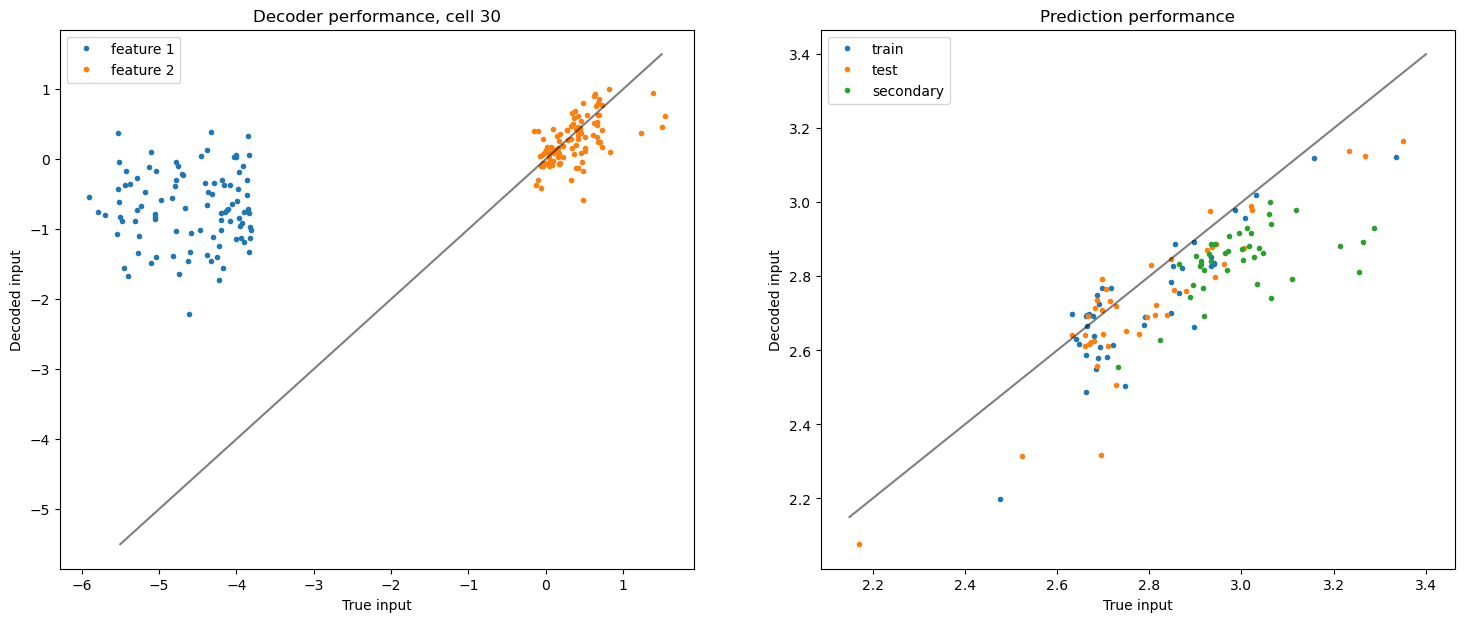


Stage 2:

Epoch 4/40, loss: 11.57
Epoch 8/40, loss: 10.00
Epoch 12/40, loss: 9.53
Epoch 16/40, loss: 9.44
Epoch 20/40, loss: 8.63
Epoch 24/40, loss: 7.68
Epoch 28/40, loss: 6.99
Epoch 32/40, loss: 6.38
Epoch 36/40, loss: 5.81
Epoch 40/40, loss: 5.23
train 	 98.06971
test 	 96.669266
sec 	 332.17368


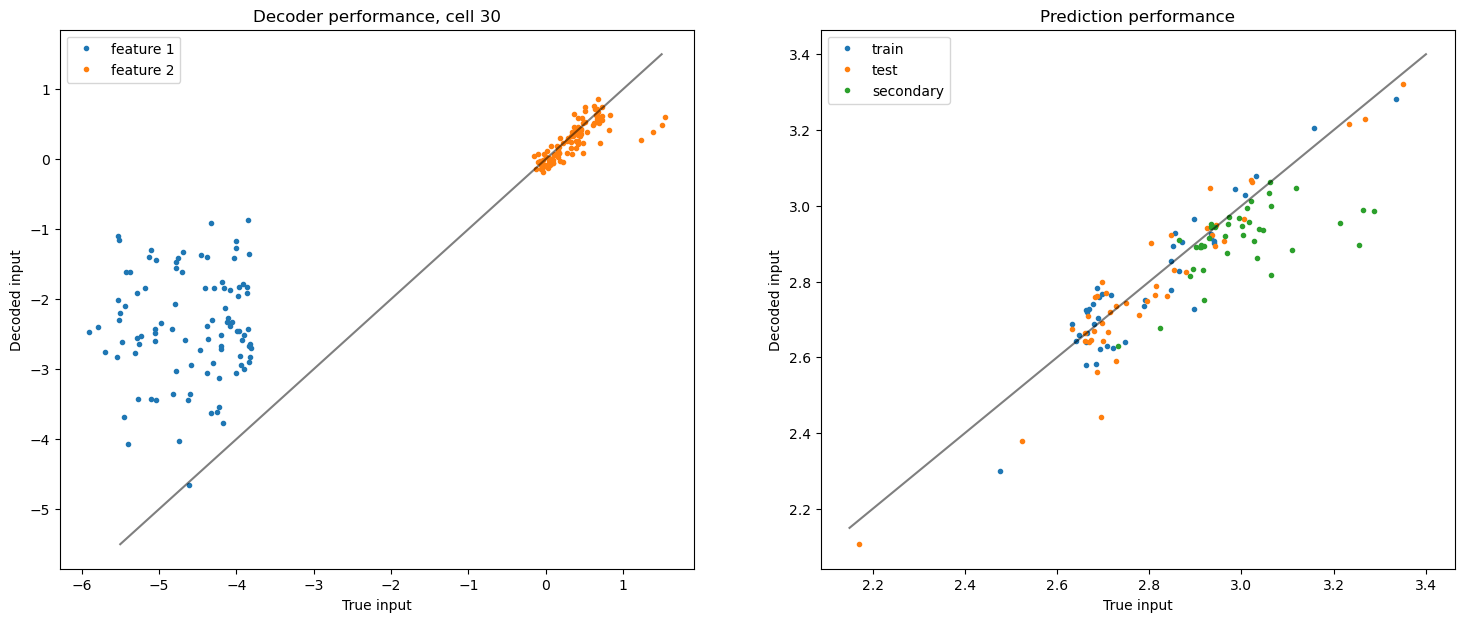


Stage 3:

Epoch 6/60, loss: 9207.30
Epoch 12/60, loss: 10101.21
Epoch 18/60, loss: 13396.93
Epoch 24/60, loss: 10361.25
Epoch 30/60, loss: 7296.07
Epoch 36/60, loss: 6305.61
Epoch 42/60, loss: 6391.53
Epoch 48/60, loss: 5714.72
Epoch 54/60, loss: 5429.92
Epoch 60/60, loss: 5272.30
train 	 71.965164
test 	 98.31194
sec 	 340.2518


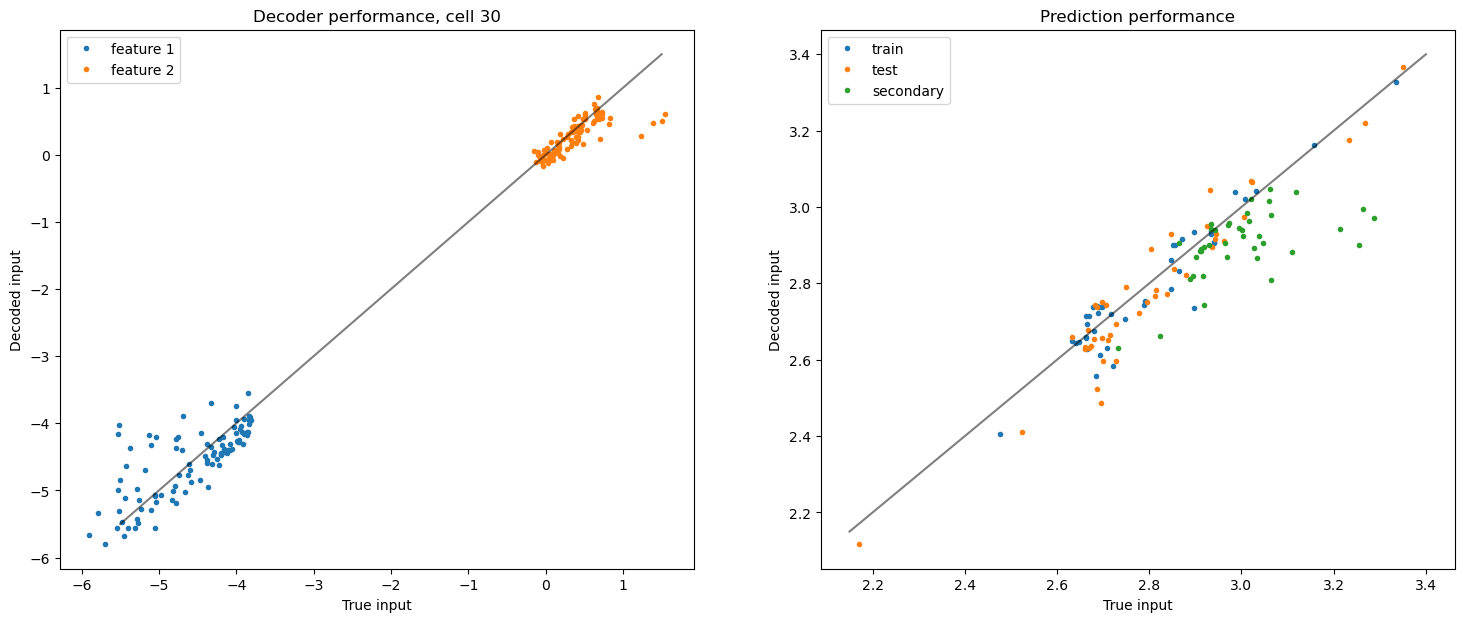

In [80]:
train_policy = {
    "num_stages": 3,
    "epochs": [30, 40, 60],
    "learning_rates": [5e-4, 5e-4, 5e-4],
    "batch_sizes": [64, 64, 64],
    "prediction_weights": [1, 0.0001, 1],
    "decoding_weights": [10, 1, 0.0001],
    "en_weights": [1, 1, 1]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [81]:
model.encoder(x[5])

tensor([0.0000, 0.0000, 2.0924, 4.5250, 1.5460, 0.0000, 0.9500, 2.9991, 0.0000,
        2.9829, 0.0000, 0.0000, 4.3640, 0.0000, 0.0000, 0.0000, 2.1230, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.1273, 0.0000,
        3.3905, 0.0000, 3.4999, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

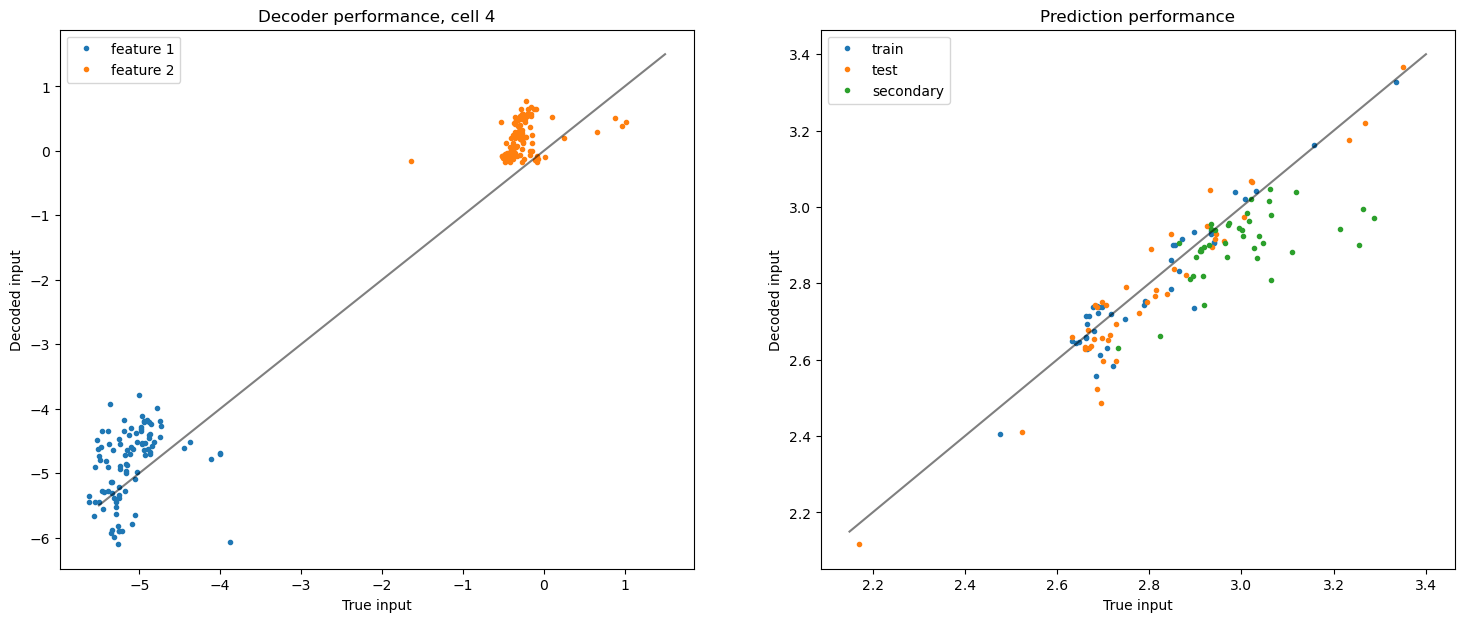

In [82]:
model.plotter(x, y, 4)

In [83]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.3270], grad_fn=<AddBackward0>)


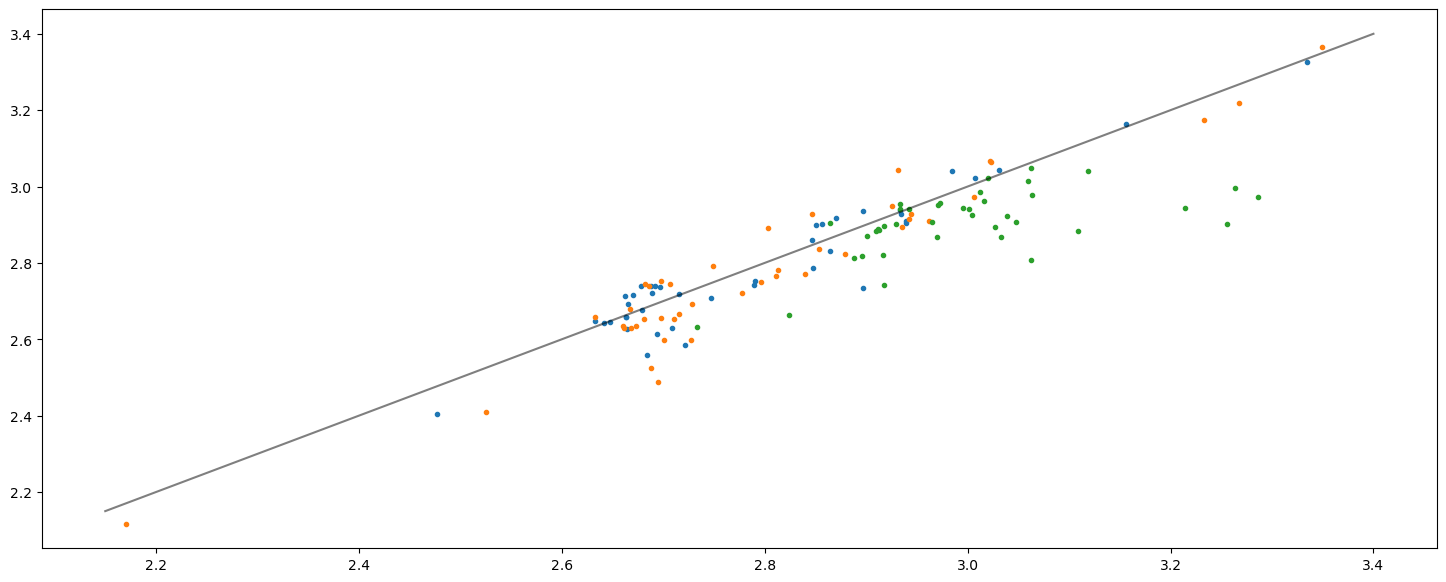

In [84]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [85]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t[0])

[0.         0.         2.5458927  4.8743873  1.5163273  0.
 0.75844646 3.083326   0.         3.0391035  0.         0.
 4.6702476  0.         0.         0.         2.332843   0.
 0.         0.         0.         0.         0.         0.
 0.         4.5563846  0.         4.014096   0.         3.9867778
 0.         0.        ]


In [86]:
scaler = preprocessing.StandardScaler().fit(list(x_t))
x_t = scaler.transform(list(x_t))
x_te = scaler.transform(list(x_te))
x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [87]:
# parameters
lr = 0.001
feat_dim = 2*16
d_model = 12
nepoch = 3000
batch_size = 1

In [88]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 50 | rmse:  625.150 | rmse_test:  722.597 | rmse_stest:  1053.019
Epochs: 100 | rmse:  611.430 | rmse_test:  669.166 | rmse_stest:  1050.412
Epochs: 150 | rmse:  608.231 | rmse_test:  680.023 | rmse_stest:  1038.735
Epochs: 200 | rmse:  599.513 | rmse_test:  649.524 | rmse_stest:  1021.195
Epochs: 250 | rmse:  614.311 | rmse_test:  619.983 | rmse_stest:  982.379
Epochs: 300 | rmse:  547.184 | rmse_test:  556.662 | rmse_stest:  871.007
Epochs: 350 | rmse:  451.148 | rmse_test:  447.977 | rmse_stest:  497.620
Epochs: 400 | rmse:  430.001 | rmse_test:  433.027 | rmse_stest:  433.068
Epochs: 450 | rmse:  420.979 | rmse_test:  440.184 | rmse_stest:  422.977
Epochs: 500 | rmse:  407.348 | rmse_test:  437.346 | rmse_stest:  419.841
Epochs: 550 | rmse:  395.144 | rmse_test:  420.843 | rmse_stest:  426.197
Epochs: 600 | rmse:  383.401 | rmse_test:  406.499 | rmse_stest:  416.648
Epochs: 650 | rmse:  357.686 | rmse_test:  384.837 | rmse_stest:  390.981
Epochs: 700 | rmse:  311.754 | rmse

In [ ]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

In [ ]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)